In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
for dirname, _, filenames in os.walk('/Tumor_MRI_Detection/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(1).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(10).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(100).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(11).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(12).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(13).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(14).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(15).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(16).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(17).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(18).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(19).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(2).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(20).jpg
/Tumor_MRI_Detection/archive\Testing\glioma_tumor\image(21).jpg
/Tumor_MRI_Detection/archive\Testing\glio

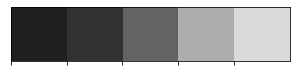

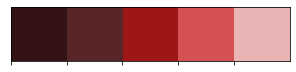

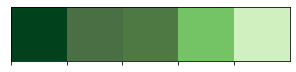

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_red)
sns.palplot(colors_green)

In [4]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

#  Data Preparation


In [5]:
X_train = []
y_Train = []
image_size = 150

for i in labels:
    folderpath = os.path.join('/Tumor_MRI_Detection/archive', 'Training',i)
    for j in tqdm(os.listdir(folderpath)):
        img = cv2.imread(os.path.join(folderpath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_Train.append(i)

for i in labels:
    folderpath = os.path.join('/Tumor_MRI_Detection/archive','Testing',i)
    for j in tqdm(os.listdir(folderpath)):
        img = cv2.imread(os.path.join(folderpath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_Train.append(i)
        
X_train = np.array(X_train)
y_Train = np.array(y_Train)
    

100%|██████████| 74/74 [00:02<00:00, 35.79it/s]


# Image From Each Label

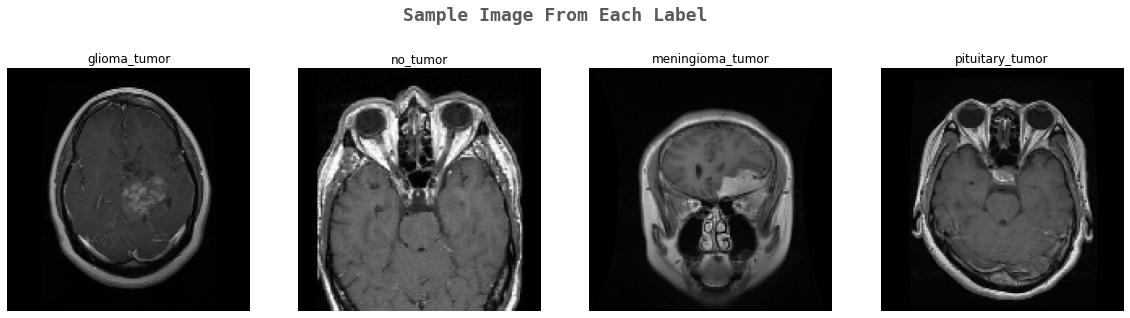

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_Train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_Train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1



In [7]:
X_train,  y_Train = shuffle(X_train,y_Train, random_state = 42 )
X_train.shape


(3264, 150, 150, 3)

# Train Test Split

In [8]:
X_train, X_test, y_Train, y_test = train_test_split(X_train, y_Train, test_size=0.2, random_state=10)

# One Hot Encdoing

In [9]:
y_Train_new = []
for i in y_Train:
    y_Train_new.append(labels.index(i))
y_Train = y_Train_new
y_Train = tf.keras.utils.to_categorical(y_Train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


# Applying Transfer Learning

In [10]:
#############Base Model##########################
effi_model = EfficientNetB0(weights= 'imagenet', include_top= False, input_shape=(image_size, image_size,3))

In [11]:
model = effi_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation = 'softmax')(model)
model = tf.keras.models.Model(inputs = effi_model.input, outputs = model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [13]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


# Training The Model

In [14]:
Hist = model.fit(X_train,y_Train,validation_split=0.1, epochs = 12, verbose = 1,batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

c:\Users\saada\Python 3.9\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/12
74/74 [==============================] - 491s 6s/step - loss: 0.5091 - accuracy: 0.8131 - val_loss: 3.2123 - val_accuracy: 0.4924

Epoch 00001: val_accuracy improved from -inf to 0.49237, saving model to effnet.h5
Epoch 2/12
74/74 [==============================] - 356s 5s/step - loss: 0.1780 - accuracy: 0.9327 - val_loss: 0.7274 - val_accuracy: 0.7939

Epoch 00002: val_accuracy improved from 0.49237 to 0.79389, saving model to effnet.h5
Epoch 3/12
74/74 [==============================] - 352s 5s/step - loss: 0.1405 - accuracy: 0.9557 - val_loss: 0.3419 - val_accuracy: 0.9008

Epoch 00003: val_accuracy improved from 0.79389 to 0.90076, saving model to effnet.h5
Epoch 4/12
74/74 [==============================] - 361s 5s/step - loss: 0.1050 - accuracy: 0.9647 - val_loss: 0.9986 - val_accuracy: 0.7366

Epoch 00004: val_accuracy did not improve from 0.90076
Epoch 5/12
74/74 [==============================] - 351s 5s/step - loss: 0.0789 - accuracy: 0.9740 - val_loss: 0.6902 - va

# Validating The Training Accuracy 

Text(0, 0.5, 'Training & Validation Loss')

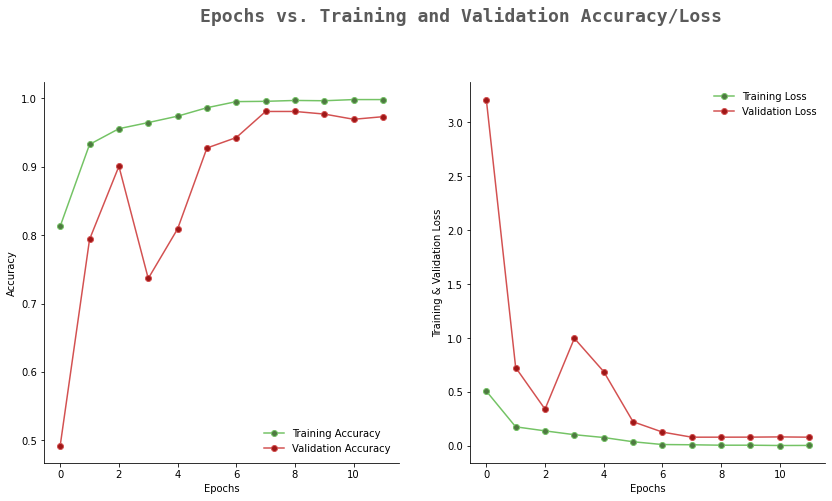

In [17]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = Hist.history['accuracy']
train_loss = Hist.history['loss']
val_acc = Hist.history['val_accuracy']
val_loss = Hist.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')



In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


# Evaluation

In [20]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       195
           1       0.93      0.99      0.96       100
           2       0.95      0.95      0.95       191
           3       0.99      0.98      0.98       167

    accuracy                           0.97       653
   macro avg       0.96      0.97      0.97       653
weighted avg       0.97      0.97      0.97       653



In [22]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [23]:
uploader = widgets.FileUpload()
display(uploader)


FileUpload(value=(), description='Upload')

In [24]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])
